In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import warnings
import seaborn as sns
import glob

warnings.filterwarnings('ignore')
font_name = matplotlib.font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
krfont = {'family':font_name, 'size':10}
matplotlib.rc('font', **krfont)
matplotlib.rcParams['axes.unicode_minus'] = False

In [2]:
# 데이터 불러오기
data = []
files = glob.glob('./data/Price_*.csv')
for f in files:
    tmp = pd.read_csv(f, encoding='CP949')
    tmp.drop(['조사구분코드','표준품목코드','조사가격품목코드','표준품종코드','조사가격품종코드','조사등급코드','표준단위코드','조사지역코드','표준시장코드','조사가격시장코드','표준단위명'], axis=1, inplace=True)
    data.append(tmp)
price = pd.concat(data)

In [3]:
# 쇠고기 데이터 추출
beef = price.query('표준품목명 == "쇠고기"').drop(['조사구분명','표준품목명','조사가격품목명','조사단위명'], axis=1)
beef['조사일자'] = beef['조사일자'].astype('datetime64[ns]')

In [4]:
# 데이터 정제
beef['원산지'] = beef['조사가격품종명'].str.extract('(미국산|호주산)(갈비|갈비살|불고기|등심)')[0]
beef['부위'] = beef['조사가격품종명'].str.extract('(미국산|호주산)(갈비|갈비살|불고기|등심)')[1]
beef['조사등급명2'] = beef['조사등급명'].apply(lambda x:{'하(3등급)':0,'상(1등급)':1}.get(x,99))
beef['시장명'] = beef['조사가격시장명'].str.extract('(시장|유통)')
beef['시점'] = beef['조사일자'].apply(lambda x:np.timedelta64(x - np.datetime64('2016-01-04'), 'D').astype(int))
df = beef.drop(['조사일자','표준품종명','조사가격품종명','조사등급명','전일조사가격','조사지역명','표준시장명','조사가격시장명'], axis=1).reset_index(drop=True)

In [128]:
# 라벨 인코딩
from sklearn.preprocessing import LabelEncoder


le1 = LabelEncoder().fit(df['원산지'])
labels1 = le1.transform(df['원산지'])
le2 = LabelEncoder().fit(df['부위'])
labels2 = le2.transform(df['부위'])
le3 = LabelEncoder().fit(df['시장명'])
labels3 = le3.transform(df['시장명'])

df['원산지2'] = labels1
df['부위2'] = labels2
df['시장명2'] = labels3
data = df.drop(['원산지','부위','시장명'], axis=1)
X = np.array(data.iloc[:,1:])
y = np.array(data.iloc[:,0]).reshape(len(data),1)

In [84]:
# 스케일링
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(y)
y_scaled = scaler.transform(y)

In [85]:
# 훈련, 테스트 데이터 분리
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y_scaled, test_size=0.2, random_state=180610)

In [86]:
from keras.models import Sequential
from keras.layers import Dense

model = Sequential()
model.add(Dense(64, input_dim=5, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='rmsprop', loss='mse')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 64)                384       
_________________________________________________________________
dense_5 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 65        
Total params: 4,609
Trainable params: 4,609
Non-trainable params: 0
_________________________________________________________________


In [87]:
hist = model.fit(X_train, y_train, epochs=50, batch_size=24)

Epoch 1/50
44624/44624 [==============================] - 1s 21us/step - loss: 10.3545
Epoch 2/50
44624/44624 [==============================] - 1s 19us/step - loss: 1.8086
Epoch 3/50
44624/44624 [==============================] - 1s 18us/step - loss: 0.8210
Epoch 4/50
44624/44624 [==============================] - 1s 19us/step - loss: 0.6293
Epoch 5/50
44624/44624 [==============================] - 1s 20us/step - loss: 0.4710
Epoch 6/50
44624/44624 [==============================] - 1s 19us/step - loss: 0.3605
Epoch 7/50
44624/44624 [==============================] - 1s 19us/step - loss: 0.2997
Epoch 8/50
44624/44624 [==============================] - 1s 19us/step - loss: 0.2735
Epoch 9/50
44624/44624 [==============================] - 1s 19us/step - loss: 0.2572
Epoch 10/50
44624/44624 [==============================] - 1s 19us/step - loss: 0.2517
Epoch 11/50
44624/44624 [==============================] - 1s 19us/step - loss: 0.2330
Epoch 12/50
44624/44624 [==========================

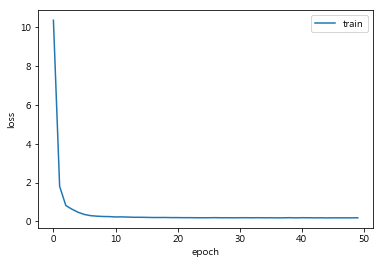

In [88]:
# 손실함수
plt.plot(hist.history['loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train'], loc='best')
plt.show()

In [101]:
# 테스트
loss = model.evaluate(X_test, y_test, batch_size=32)
print('Loss : {:.2f}'.format(loss))

11156/11156 [==============================] - 0s 6us/step
Loss : 0.17


In [186]:
# 예측
t = 1000
X_pred = np.array([[0,t,0,0,0],
                   [0,t,0,0,1],
                   [0,t,0,1,0],
                   [0,t,0,1,1],
                   [0,t,0,2,0],
                   [0,t,0,2,1],
                   [0,t,1,0,0],
                   [0,t,1,0,1],
                   [0,t,1,1,0],
                   [0,t,1,1,1],
                   [0,t,1,2,0],
                   [0,t,1,2,1],
                   [1,t,0,0,0],
                   [1,t,0,0,1],
                   [1,t,0,1,0],
                   [1,t,0,1,1],
                   [1,t,0,2,0],
                   [1,t,0,2,1],
                   [1,t,1,0,0],
                   [1,t,1,0,1],
                   [1,t,1,1,0],
                   [1,t,1,1,1],
                   [1,t,1,2,0],
                   [1,t,1,2,1]])
y_pred = scaler.inverse_transform(model.predict(X_pred))

In [202]:
# 결과 출력
result = pd.DataFrame()
result['시점'] = np.datetime64('2016-01-04')+X_pred[:,1]
result['조사등급명'] = X_pred[:,0]
result['원산지'] = le1.inverse_transform(X_pred[:,2])
result['부위'] = le2.inverse_transform(X_pred[:,3])
result['시장명'] = le3.inverse_transform(X_pred[:,4])
result['예측가격'] = np.round(y_pred).astype(int)
result.sort_values(by='예측가격', ascending=False, inplace=True)
result.head()

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


,시점,조사등급명,원산지,부위,시장명,예측가격
21,2018-09-30,1,호주산,등심,유통,3783
15,2018-09-30,1,미국산,등심,유통,3275
6,2018-09-30,0,호주산,갈비,시장,2412
7,2018-09-30,0,호주산,갈비,유통,2335
18,2018-09-30,1,호주산,갈비,시장,2326


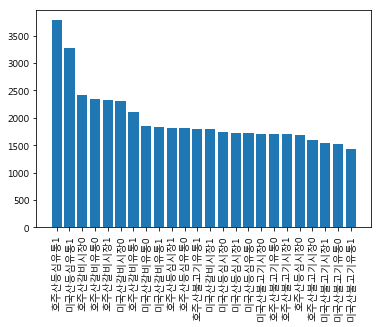

In [203]:
plt.bar(result['원산지'] + result['부위'] + result['시장명'] + result['조사등급명'].astype(str), result['예측가격'])
plt.xticks(rotation=90)
plt.show()